In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab import drive

np.random.seed(42)
drive.mount('/content/drive')
dataset_path = "/content/drive/My Drive/animal_dataset"
classes = sorted(os.listdir(dataset_path))
label_map = {cls_name: idx for idx, cls_name in enumerate(classes)}

print("Classes:", classes)


Mounted at /content/drive
Classes: ['cat', 'dog', 'panda']


In [2]:
X = []
y = []

for cls_name in classes:
    folder = os.path.join(dataset_path, cls_name)
    for img_name in os.listdir(folder):
        path = os.path.join(folder, img_name)

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (32, 32))
        img = img.astype(np.float32) / 255.0
        img = img.flatten()

        X.append(img)
        y.append(label_map[cls_name])

X = np.array(X)
y = np.array(y)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)


Dataset shape: (300, 1024)
Labels shape: (300,)


In [3]:
def L1(a, b):
    return np.sum(np.abs(a - b))

def L2(a, b):
    return np.sqrt(np.sum((a - b)**2))


In [4]:
def knn_predict(X_train, y_train, x_test, K, metric):
    distances = []

    for i in range(len(X_train)):
        if metric == "L1":
            d = L1(X_train[i], x_test)
        else:
            d = L2(X_train[i], x_test)
        distances.append((d, y_train[i]))

    distances.sort(key=lambda x: x[0])

    k_neighbors = distances[:K]
    labels = [label for _, label in k_neighbors]

    counts = np.bincount(labels)
    return np.argmax(counts)


In [5]:
def five_fold_indices(N):
    indices = np.arange(N)
    np.random.shuffle(indices)
    fold_size = N // 5
    folds = []

    for i in range(5):
        start = i * fold_size
        end = (i + 1) * fold_size
        folds.append(indices[start:end])

    return folds


In [6]:
K_list = [1, 3, 5, 7, 9, 11, 15, 20, 25]
avg_acc_l1 = {}
avg_acc_l2 = {}

folds = five_fold_indices(len(X))

for K in K_list:
    acc_l1 = []
    acc_l2 = []

    for i in range(5):
        test_idx = folds[i]
        train_idx = np.concatenate([folds[j] for j in range(5) if j != i])

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        correct_l1 = 0
        correct_l2 = 0

        for j in range(len(X_test)):
            pred_l1 = knn_predict(X_train, y_train, X_test[j], K, "L1")
            pred_l2 = knn_predict(X_train, y_train, X_test[j], K, "L2")

            if pred_l1 == y_test[j]:
                correct_l1 += 1
            if pred_l2 == y_test[j]:
                correct_l2 += 1

        acc_l1.append(correct_l1 / len(X_test))
        acc_l2.append(correct_l2 / len(X_test))

    avg_acc_l1[K] = np.mean(acc_l1)
    avg_acc_l2[K] = np.mean(acc_l2)

print("L1 accuracy:", avg_acc_l1)
print("L2 accuracy:", avg_acc_l2)


L1 accuracy: {1: np.float64(0.3633333333333333), 3: np.float64(0.35), 5: np.float64(0.36), 7: np.float64(0.36333333333333334), 9: np.float64(0.3966666666666666), 11: np.float64(0.39666666666666667), 15: np.float64(0.41000000000000003), 20: np.float64(0.39), 25: np.float64(0.4366666666666667)}
L2 accuracy: {1: np.float64(0.35), 3: np.float64(0.33999999999999997), 5: np.float64(0.32999999999999996), 7: np.float64(0.39666666666666667), 9: np.float64(0.3833333333333333), 11: np.float64(0.35), 15: np.float64(0.36666666666666664), 20: np.float64(0.3866666666666667), 25: np.float64(0.38333333333333336)}


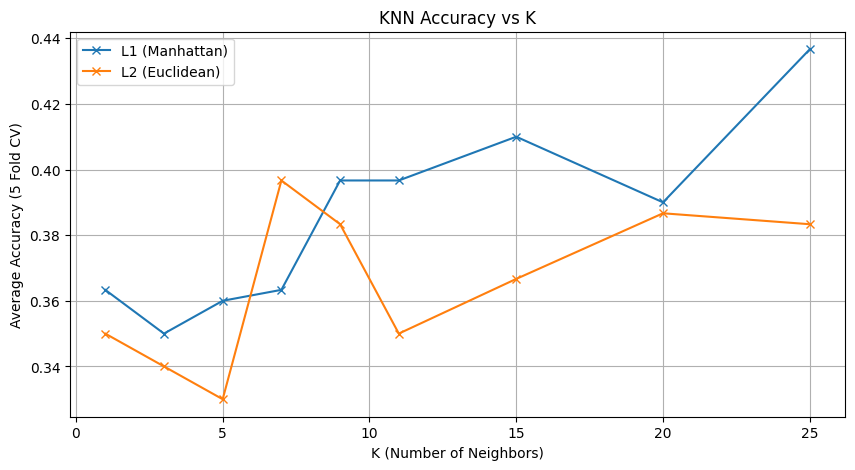


Best K = 25, Best Metric = L1


In [7]:
K_values = list(avg_acc_l1.keys())
acc_l1 = list(avg_acc_l1.values())
acc_l2 = list(avg_acc_l2.values())

plt.figure(figsize=(10,5))
plt.plot(K_values, acc_l1, 'x-', label='L1 (Manhattan)')
plt.plot(K_values, acc_l2, 'x-', label='L2 (Euclidean)')
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Average Accuracy (5 Fold CV)")
plt.title("KNN Accuracy vs K")
plt.grid(True)
plt.legend()
plt.show()

best_k_l1 = K_values[np.argmax(acc_l1)]
best_k_l2 = K_values[np.argmax(acc_l2)]

if max(acc_l1) > max(acc_l2):
    best_K = best_k_l1
    best_metric = "L1"
else:
    best_K = best_k_l2
    best_metric = "L2"

print(f"\nBest K = {best_K}, Best Metric = {best_metric}")



Top-5 Predictions:

Image index 248 actual class = 2
Top-5 neighbor predictions: [np.int64(0), np.int64(1), np.int64(2), np.int64(1), np.int64(0)]

Image index 198 actual class = 1
Top-5 neighbor predictions: [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]

Image index 164 actual class = 1
Top-5 neighbor predictions: [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]

Image index 71 actual class = 0
Top-5 neighbor predictions: [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0)]

Image index 132 actual class = 1
Top-5 neighbor predictions: [np.int64(1), np.int64(2), np.int64(1), np.int64(0), np.int64(1)]



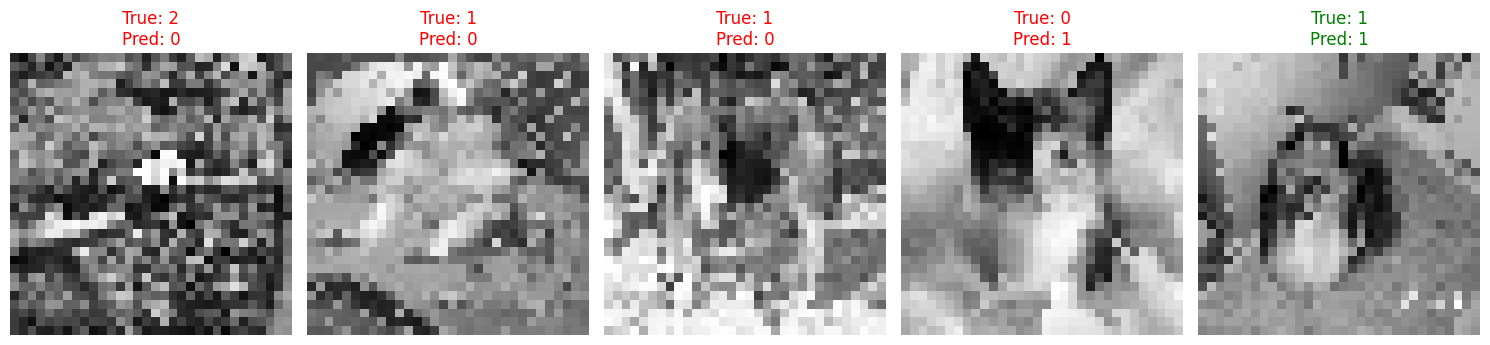

In [8]:
indices = np.random.choice(len(X), 5, replace=False)

print("\nTop-5 Predictions:\n")

plt.figure(figsize=(15, 4))

plot_pos = 1

for idx in indices:
    x_query = X[idx]

    distances = []
    for i in range(len(X)):
        if i == idx:
            continue

        if best_metric == "L1":
            d = L1(X[i], x_query)
        else:
            d = L2(X[i], x_query)

        distances.append((d, y[i]))

    distances.sort(key=lambda x: x[0])

    top5 = distances[:5]
    preds = [lbl for _, lbl in top5]

    pred_lbl = np.bincount(preds).argmax()
    true_lbl = y[idx]

    print(f"Image index {idx} actual class = {true_lbl}")
    print("Top-5 neighbor predictions:", preds)
    print()

    ax = plt.subplot(1, 5, plot_pos)
    plot_pos += 1

    img = x_query.reshape(32, 32)
    plt.imshow(img, cmap='gray')

    color = "green" if pred_lbl == true_lbl else "red"
    plt.title(f"True: {true_lbl}\nPred: {pred_lbl}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [9]:
print(X.shape)
print(X[0].shape)
print("L1:", L1(X[0], X[1]))
print("L2:", L2(X[0], X[1]))



(300, 1024)
(1024,)
L1: 383.5412
L2: 15.082621
